In [1]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../src/rise.css", "r").read()
    return HTML(styles)
css_styling()

# INTRODUCTION
<a href="http://ibb.co/hxXdKx"><img src="http://preview.ibb.co/cgA9Rc/ww2.png" alt="ww2" border="0" height = 180></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization library
import matplotlib.pyplot as plt # visualization library
import plotly.graph_objs as go # plotly graphical object

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))
# import warnings library
import warnings        
# ignore filters
warnings.filterwarnings("ignore") # if there is a warning after some codes, this will avoid us to see them.
plt.style.use('ggplot') # style of plots. ggplot is one of the most used style, I also like it.

['.ipynb_checkpoints', '1_gFC2bTg3uihp1klknWU0qg.gif', 'airline_passengers.csv', 'AirQualityUCI', 'demand_store_forecast', 'graph.png', 'holt winter.png', 'Holt-winter additive.png', 'Holt-winter single exponential smoothing.png', 'macrodata.csv', 'operations', 'sample_data.csv', 'Summary of Weather', 'Weather Station Locations.csv']


* We use 3 data sources.
    * <span style="color:#00a19b">Aerial Bombing Operations in WW2 </span>
        * Shortly, this data includes bombing operations. For example, USA who use ponte olivo airfield bomb Germany (Berlin) with A36 air craft in 1945.
    * <span style="color:#00a19b">Weather Conditions in WW2 </span>
        * Shortly, weather conditions during ww2. For example, according to george town weather station, average temperature is 23.88 in 1/7/1942. 
        * This data set has 2 subset in it. First one includes weather station locations like <u>country, latitude and longitude.</u>
        * Second one includes measured <u>min, max and mean </u> temperatures from weather stations.

In [3]:
# Load the data here
aerial = pd.read_csv("../input/operations/operations.csv")
# Let's look at the data.
aerial.head()

# first weather data that includes locations like country, latitude and longitude.
weather_station_location = pd.read_csv("../input/Weather Station Locations.csv")
weather_station_location = weather_station_location.loc[:,["WBAN","NAME","STATE/COUNTRY ID","Latitude","Longitude"] ]

# Second weather data that includes measured min, max and mean temperatures
weather = pd.read_csv("../input/Summary of Weather/Summary of Weather.csv")

In [4]:
aerial["year"] = [ each.split("/")[2] for each in aerial["Mission Date"]]
aerial["month"] = [ each.split("/")[0] for each in aerial["Mission Date"]]
aerial = aerial[aerial["year"]>="1943"]
aerial = aerial[aerial["month"]>="8"]

aerial["Mission Date"] = pd.to_datetime(aerial["Mission Date"])

attack = "USA"
target = "BURMA"
city = "KATHA"

## Filter Country, Target Country and Target City here. 
aerial_war = aerial[aerial.Country == attack]
aerial_war = aerial_war[aerial_war["Target Country"] == target]
aerial_war = aerial_war[aerial_war["Target City"] == city]

Create a new column called year by getting the year of attack from the "Mission Date" column. Filter only after year 1943.

<p> Create a new dataframe alled `aerial_war` and filter the Country as 'USA', Target Country as "BURMA" and Target City as "KATHA". </p>

* Lets focus **USA and BURMA war**
* In this war USA bomb BURMA( KATHA city) from 1942 to 1945.
* The closest weather station to this war is **BINDUKURI** and it has temperature record from 1943 to 1945.
* Now lets visualize this situation. But before visualization, we need to make <span style="color:blue">date features date time object.</span>

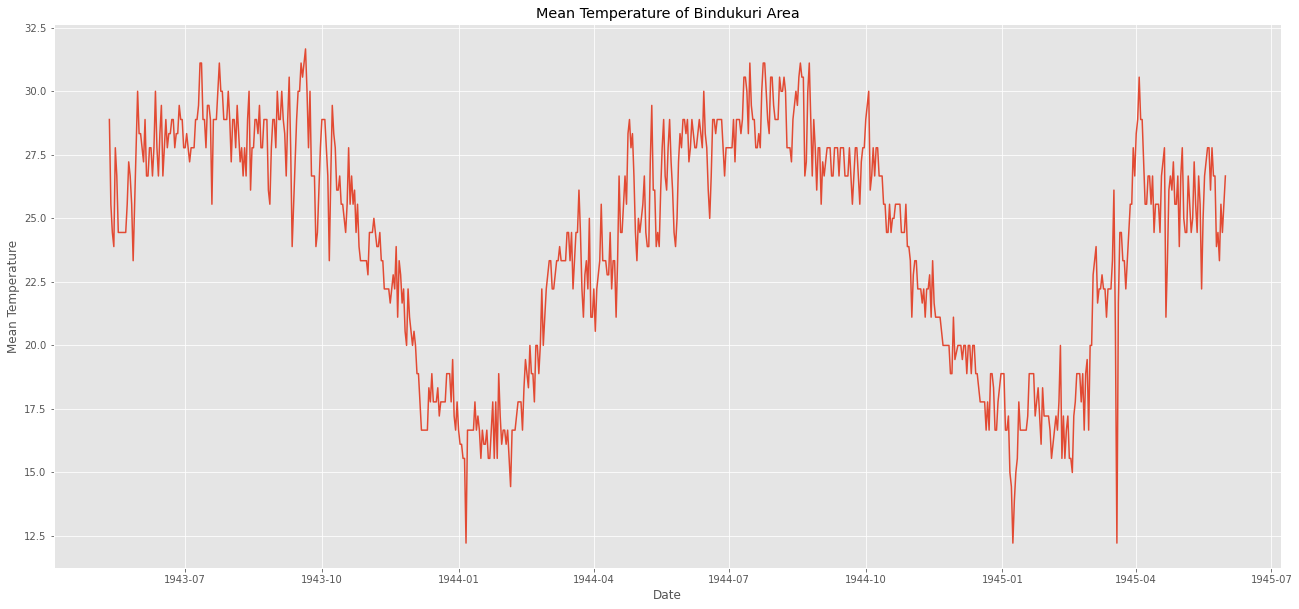

In [5]:
weather_station_id = weather_station_location[weather_station_location.NAME == "BINDUKURI"].WBAN 
weather_bin = weather[weather.STA == 32907]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

For each of the date of attack in `Mission Date`, get the MeanTemp of the city of that date from `weather_bin` dataframe. 

* As you can see, we have temperature measurement from 1943 to 1945.
* Temperature ossilates between 12 and 32 degrees. 
* Temperature of  winter months is colder than  temperature of  summer months.

In [11]:
liste = []
aa = []
for each in aerial_war["Mission Date"]:
    dummy = weather_bin[weather_bin.Date == each]
    liste.append(dummy["MeanTemp"].values)
aerial_war["dene"] = liste
for each in aerial_war.dene.values:
    aa.append(each[0])

In [12]:
# Create a trace
trace = go.Scatter(
    x = weather_bin.Date,
    mode = "lines",
    y = weather_bin.MeanTemp,
    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),
    name = "Mean Temperature"
)
trace1 = go.Scatter(
    x = aerial_war["Mission Date"],
    mode = "markers",
    y = aa,
    marker = dict(color = 'rgba(16, 0, 200, 1)'),
    name = "Bombing temperature"
)
layout = dict(title = 'Mean Temperature --- Bombing Dates and Mean Temperature at this Date')
data = [trace,trace1]

# fig = dict(data = data, layout = layout)
# iplot(fig)
fig = go.Figure(data=data, layout=layout)
fig.show()


* Green line is mean temperature that is measured in Bindukuri.
* Blue markers are bombing dates and bombing date temperature.
* As it can be seen from plot, USA bomb at high temperatures.
    * The question is that can we predict future weather and according to this prediction can we know whether bombing will be done or not.
    * In order to answer this question lets first start with time series prediction.
  

* The way that we will follow: 
    * What is Time Series ?
    * Stationarity of a Time Series
    * Make a Time Series Stationary?
    * Forecasting a Time Series

### What is time series?
* Time series is a collection of data points that are collected at constant time intervals.
* It is time dependent.
* Most (BUT NOT ALL) of time series have some form of **seasonality trends**. For example, if we sell ice cream, most probably there will be higher sales in summer. Therefore, this time series has seasonality trends.
* Another example, let's think we dice one time every day during 1 year. There will be no scenario like that number six is appeared mostly in summer season or number five is mostly appeared in January. Therefore, this time series does not have seasonality trends.

# BREAKOUT

### Stationarity of a Time Series
* There are three basic criterion for a time series to understand whether it is stationary series or not.
    * Statistical properties of time series such as mean, variance should remain constant over time to call **time series is stationary**
        * constant mean
        * constant variance
        * autocovariance that does not depend on time. autocovariance is covariance between time series and lagged time series.
* Lets visualize and check seasonality trend of our time series.

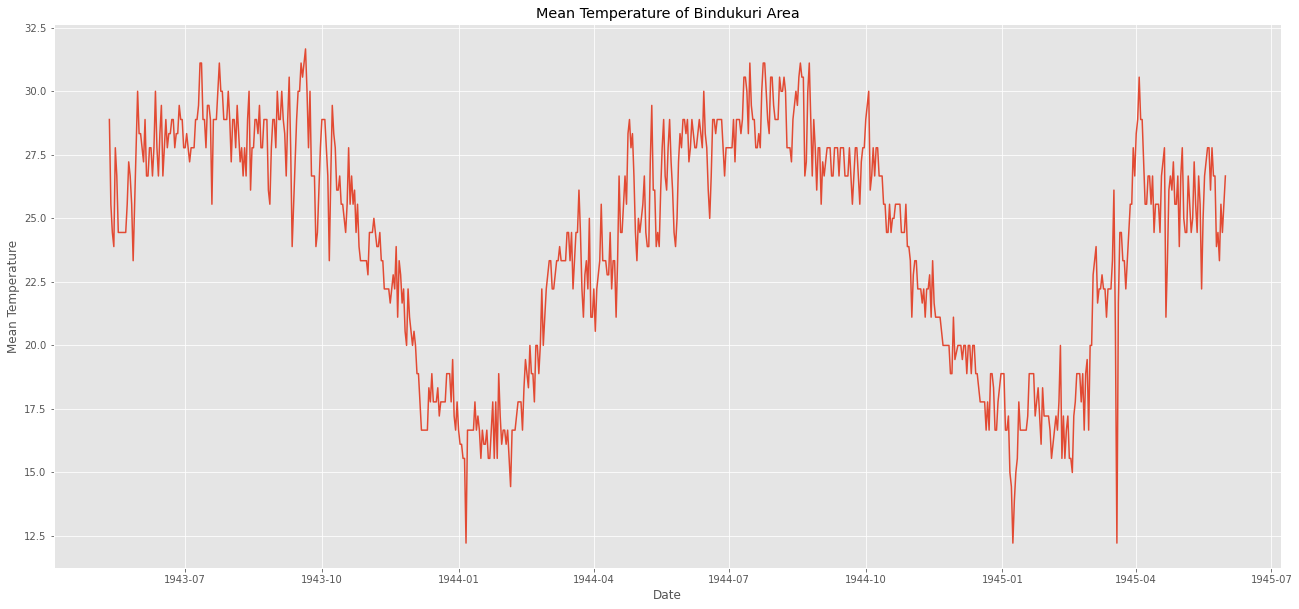

In [7]:
# Mean temperature of Bindikuri area
plt.figure(figsize=(22,10))
plt.plot(weather_bin.Date,weather_bin.MeanTemp)
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

In [8]:
# lets create time series from weather 
timeSeries = weather_bin.loc[:, ["Date","MeanTemp"]]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date",axis=1)

* As you can see from plot above, our time series has seasonal variation. In summer, mean temperature is higher and in winter mean temperature is lower for each year.
* Now lets check stationarity of time series. We can check stationarity using the following methods: 
    * Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.
    * Dickey-Fuller Test: The test results comprise of a **Test Statistic** and some **Critical Values** for difference confidence levels. If the **test statistic** is less than the **critical value**, we can say that time series is stationary.

More info : <a href="https://www.statsmodels.org/stable/api.html#statistics-and-tests"> Statistics for Time Series</a>

In [9]:
# import adfuller here

# def a 'check_adfuller' function that takes in argument (ts) here. Print test statistic and p-value and  critical value.

def check_adfuller(ts):
    """Performs the dickey-fuller test using the statsmodels tsa package."""

Define a `check_mean_std` function that takes in argument `(ts)` here. For `rolling mean`, take a window of 6. 
For more info, refer this link. 

<a href="https://www.geeksforgeeks.org/python-pandas-dataframe-rolling/">Pandas Rolling</a>

In [10]:
def check_mean_std (ts):
    """ Get a rolling statistics of mean of ts, window size =6. Get rolling std of window size 6. 
    Return a plot showing the original ts, rolling mean and rolling std."""
    
    # Calculate Rolling statistics
    rolmean = 
    rolstd = 

    # Plot the rolling mean & rolling std
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-10-367cfa3e3f66>, line 6)

In [ ]:
# Execute your check_adfuller function and check_mean_std here.


What can you intepret from the tests?

### Make a Time Series Stationary?
* As we mentioned before, there are 2  reasons behind non-stationarity of time series
    * Trend: varying mean over time. We need <span style="color:purple">constant mean for stationary of time series</span>.
    * Seasonality: <span style="color:purple">variations at specific time. </span> We need constant variations for stationary of time series.
* First solve **trend(constant mean)** problem
    * Most popular method is moving average.<i>(To be covered in Day 3)</i>
        * Moving average: We have window that take the average over the past 'n' sample. 'n' is window size.
* Second method:
We will use the <b>differencing</b> method to convert to stationary.

In [ ]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method") 
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

In [ ]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values

# check stationarity: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff.MeanTemp)

Constant mean criteria: mean looks like constant as you can see from plot(black line) above . (yes stationary)
Second one is constant variance. It looks like constant. (yes stationary)
The test statistic is smaller than the 1% critical values so we can say with 99% confidence that this is a stationary series. (yes stationary)

### Finding ACF and PACF

Using the `statsmodels.tsa` module, let's import acf and pacf. 

Refer here for more info: https://www.statsmodels.org/stable/api.html#statistics-and-tests

In [ ]:
# import your acf and pacf here


Calculate the <u>lag_acf</u> using the `acf` function and <u>lag_pacf</u> using the `pacf` function above for <b> 20 lags </b>.

In [ ]:
# Complete the following
lag_acf = 
lag_pacf = 

Plot the ACF and PACF of the differenced-time series. 

In [ ]:
# ACF Plot 
plt.figure(figsize=(22,10))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF Plot
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

* 1. What can you interpret?
* 2. What are the two dotted lines?
* 3. How do you determine 'p' and 'q' values (TO BE COVERED IN DAY 3)?


## END